<a href="https://colab.research.google.com/github/visiont3lab/flask-static-website/blob/master/Regression_going_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA

## Polinomial Regression

## Get the data

---



In [116]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Deal With null variables

In [14]:
df = housing.drop("median_house_value", axis=1) # drop labels for training set
df_labels = housing["median_house_value"].copy()

In [15]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0


In [16]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat


In [17]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0


In [22]:
median = df["total_bedrooms"].median() # la mediana deve essere calcolata sul train set
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,NEAR BAY,3.0
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,NEAR BAY,2.0
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,NEAR BAY,2.0
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,NEAR BAY,4.0
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,NEAR BAY,3.0


In [24]:
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy="median")
housing_num = df.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

# Compara le mediane
print(imputer.statistics_)
print(housing_num.median().values)

X = imputer.transform(housing_num)
# Pandas training dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
display(housing_tr.head())
display(housing_tr.loc[sample_incomplete_rows.index.values])

# Check  imputer strategy
imputer.strategy

[-118.49     34.26     29.     2127.      435.     1166.      409.
    3.5348    3.    ]
[-118.49     34.26     29.     2127.      435.     1166.      409.
    3.5348    3.    ]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,3.0
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,2.0
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,2.0
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,4.0
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,3.0


'median'

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),  # l'ultimo deve contenere un fit_transform method
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
# Pandas training dataframe
housing_tr = pd.DataFrame(housing_num_tr, columns=housing_num.columns,index=housing_num.index)
display(housing_tr.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,1.890128
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.890128
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.890128
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.941894
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,-0.006340


In [35]:
# Save pipeline

my_model = num_pipeline
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Use different steps
my_model_loaded.named_steps["selector"].transform(housing_num)
my_model_loaded.named_steps["imputer"].transform(housing_num)
my_model_loaded.named_steps["std_scaler"].transform(housing_num)

array([[-1.32783522,  1.05254828,  0.98214266, ..., -0.97703285,
         2.34476576,  1.89012782],
       [-1.32284391,  1.04318455, -0.60701891, ...,  1.66996103,
         2.33223796,  1.89012782],
       [-1.33282653,  1.03850269,  1.85618152, ..., -0.84363692,
         1.7826994 ,  1.89012782],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.17404163,
        -1.14259331, -0.95457381],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.39375258,
        -1.05458292, -0.95457381],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.07967221,
        -0.78012947, -0.95457381]])

## Deal with categorical Variables

In [50]:
from sklearn.preprocessing import OneHotEncoder

df = housing.drop("median_house_value", axis=1) # drop labels for training set
df_labels = housing["median_house_value"].copy()

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

df = cat_pipeline.fit_transform(df)
df = pd.DataFrame(df)
display(df.head())

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [123]:
from sklearn.pipeline import FeatureUnion

# Union Pipeline

df = housing.drop(["median_house_value"], axis=1) # drop labels for training set
df_labels = housing["median_house_value"].copy()

num_attribs = df.keys().tolist()
num_attribs.remove("ocean_proximity")
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
        
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)
print(housing_prepared.shape)


# Acces feature union
full_pipeline.transformer_list[0][1].named_steps["std_scaler"]

[[-1.32783522  1.05254828  0.98214266 ...  0.          1.
   0.        ]
 [-1.32284391  1.04318455 -0.60701891 ...  0.          1.
   0.        ]
 [-1.33282653  1.03850269  1.85618152 ...  0.          1.
   0.        ]
 ...
 [-0.8237132   1.77823747 -0.92485123 ...  0.          0.
   0.        ]
 [-0.87362627  1.77823747 -0.84539315 ...  0.          0.
   0.        ]
 [-0.83369581  1.75014627 -1.00430931 ...  0.          0.
   0.        ]]
(20640, 13)


StandardScaler(copy=True, with_mean=True, with_std=True)

## Test set Creation

In [7]:
from sklearn.model_selection import train_test_split
df = housing.copy()
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

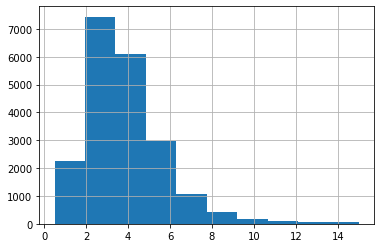

In [8]:
df["median_income"].hist()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

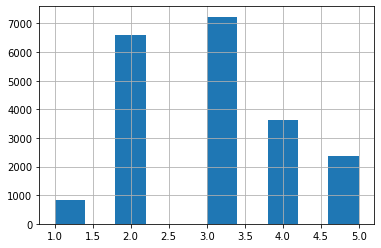

In [11]:
df["income_cat"] = np.ceil(df["median_income"] / 1.5)
df["income_cat"].where(df["income_cat"]< 5, 5.0, inplace=True)
display(housing["income_cat"].value_counts())
housing["income_cat"].hist()

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
  
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))
print(df["income_cat"].value_counts() / len(housing))

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Fine tuning

In [97]:
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()
display(housing.head())

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


df = train_set.drop("median_house_value", axis=1) # drop labels for training set
df_labels = train_set["median_house_value"].copy()

num_attribs = df.keys().tolist()
num_attribs.remove("ocean_proximity")
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
        
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("random_forest", RandomForestRegressor(random_state=42))
    ])

full_pipeline_with_predictor.fit(train_set, df_labels)
'''
param_grid = {'random_forest__n_estimators': [3,10,30],
              'random_forest__max_features': [2,4,6,8]
            }
grid_search = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df, df_labels)
'''

my_model = full_pipeline_with_predictor #grid_search.best_estimator_
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


['my_model.pkl']

In [113]:
from sklearn.metrics import mean_squared_error
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

final_model =  joblib.load("my_model.pkl") # DIFF

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

X_test_prepared = final_model.named_steps["preparation"].transform(X_test)
final_predictions = final_model.named_steps["random_forest"].predict(X_test_prepared)


final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse


48941.70034309343